### Load the libraries

In [2]:
library(pracma)
library(igraph)

### Load the functions

In [3]:
m_s=function(y,s){
  a=mean(y^s)
  a=a^(1/s)
  return(a)
}
obj_power.k.means=function(X,theta,s){
  s1=0
  n=dim(X)[1]
  k=dim(theta)[1]
  y=numeric(k)
  for(i in 1:n){
    for(j in 1:k){
      y[j]=sum((X[i,]-theta[j,])^2)
    }
    s1=s1+m_s(y,s)
  }
  return(s1)
}

power.k.means=function(X,s=-1,k,eta=1.04,
                       tmax=200,tol=10^(-3)){
  n=dim(X)[1]
  p=dim(X)[2]
  W=matrix(0,nrow=n,ncol=k)
  m=matrix(0,nrow=n,ncol=k)
  label=numeric(n)
  dd=numeric(k)
  #initialization
  sam=sample(n,k)
  theta=X[sam,]
  #theta=rand(k,p)
  #theta=rand(k,p)
  for(i in 1:p){
    theta[,i]=theta[,i]+rnorm(k,0,0.1)
  }
  val1=theta
  coef = numeric(n)
  for(t in 1:tmax){
    if(t==tmax){
      cat(coef)
      cat("\n")
      cat(W[1,])
      cat("\n")
    }
    #update weights
    for(i in 1:n){
      for(l in 1:k){
        m[i,l]=sum((X[i,]-theta[l,])^2)
      }
      coef[i] = (sum(m[i,]^s))^((1/s)-1)
    }
    for(i in 1:n){
      for(l in 1:k){
        W[i,l]=m[i,l]^(s-1)*coef[i]
      }
    }
    #update centroids
    for(l in 1:k){
      for(d in 1:p){
        theta[l,d]=(sum(W[,l]*X[,d]))/sum(W[,l])
      }
    }
    #update s
    if(t%%2==0){s=eta*s}
    cat(t)
    cat('\n')
    t=t+1
    val2=theta
    if(norm(val1-val2)<tol){
      break
    }else{
      val1=val2
    }
  }
  for(i in 1:n){
    for(j in 1:k){
      dd[j]=sum((X[i,]-theta[j,])^2)
    }
    label[i]=which.min(dd)
  }
  list1=list(theta,label)
  names(list1)=c('theta','label')
  return(list1)
}

entropy_obj_weighted.power.k.means=function(X,theta,s,W,lambda){
  s1=0
  n=dim(X)[1]
  k=dim(theta)[1]
  y=numeric(k)
  for(i in 1:n){
    for(j in 1:k){
      y[j]=sum((X[i,]-theta[j,])^2*W)
    }
    s1=s1+m_s(y,s)
  }
  s1=s1+lambda*sum(W*log(W))
  return(s1)
}

w.norm=function(y,w,beta){
  return(sum(y^2*w^(beta)))
}
entropy_weight.power.k.means=function(X,s=-1,k,lambda,eta=1.04,beta=1,tmax=200,tol=10^(-5)){
  n=dim(X)[1]
  p=dim(X)[2]
  phi=matrix(0,nrow=n,ncol=k)
  m=matrix(0,nrow=n,ncol=k)
  label=numeric(n)
  dd=numeric(k)
  #initialization
  sam=sample(n,k)
  theta=X[sam,]
  #theta=rand(k,p)
  #theta=rand(k,p)
  for(i in 1:p){
    theta[,i]=theta[,i]+rnorm(k,0,0.1)
  }
  W=rep(1/p,p)
  D=rep(0,p)
  val1=theta
  
  for(t in 1:tmax){
    #update membership
    for(i in 1:n){
      for(l in 1:k){
        m[i,l]=w.norm((X[i,]-theta[l,]),W,beta)
      }
    }
    for(i in 1:n){
      for(l in 1:k){
        phi[i,l]=(m[i,l]+0.0001)^(s-1)*(sum(m[i,]^s)+0.0001)^((1/s)-1)
      }
    }
    #update centroids
    for(l in 1:k){
      for(d in 1:p){
        theta[l,d]=(sum(phi[,l]*X[,d]))/sum(phi[,l])
      }
    }
    #update s
    if(t%%2==0){
    s=eta*s
    }
    #update feature weights
    for(l in 1:p){
      s1=0
      for(i in 1:n){
        for(j in 1:k){
          s1=s1+phi[i,j]*(X[i,l]-theta[j,l])^2
        }
      }
      D[l]=exp(-s1/lambda)
    }
    W=D/sum(D)
    cat(t)
    cat('\n')
    t=t+1
    val2=theta
    if(norm(val1-val2)<tol){
      break
    }else{
      val1=val2
    }
  }
  for(i in 1:n){
    for(j in 1:k){
      dd[j]=sum((X[i,]-theta[j,])^2*W)
    }
    label[i]=which.min(dd)
  }
  list2=list(theta,label,W)
  names(list2)=c('theta','label','weight')
  return(list2)
}
data_generate=function(n,M,prob1,sigma,sigma2){
  p=dim(M)[2]
  X=matrix(0,n,p)
  k=dim(M)[1]
  label=numeric(n)
  for(i in 1:n){
    s=sample(1:k,size=1,prob=prob1)
    for(l in 1:p){
      if(M[s,l]==0){
        X[i,l]=rnorm(1,M[s,l],sigma2)
      }else{
        X[i,l]=rnorm(1,M[s,l],sigma)
      }

    }
    label[i]=s
  }
  ls=list(X,label)
  names(ls)=c('data','label')
  return(ls)
}

### Generate the Data

In [57]:
k=5
p=20
M=rand(k,p)

prop=0.95
s=sample(p,floor(p*prop))
s=6:20
M[,s]=0
X=data_generate(1000,M,rep(1/k,k),0.02,1)
toss=X$label
X=X$data

Normalise the data (optional)

In [59]:
p=dim(X)[2]
for(i in 1:p){
  X[,i]=(X[,i]-mean(X[,i]))/sd(X[,i])
}

In [74]:
l=entropy_weight.power.k.means(X,k=k,s=-1,lambda=10,tmax=200,tol=0.001)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [75]:
compare(toss,l$label,'nmi')
compare(toss,l$label,'adjusted.rand')

[1] 1

[1] 1

In [76]:
l$weight

[1] 1.380122e-01 2.022638e-01 1.626456e-01 2.649279e-01 2.321505e-01
 [6] 7.982355e-42 5.270885e-42 8.870925e-42 8.440336e-42 6.962779e-42
[11] 8.157355e-42 9.442068e-42 7.427354e-42 7.562018e-42 1.284126e-41
[16] 6.361573e-42 1.165107e-41 2.477490e-41 8.287841e-42 9.015744e-42

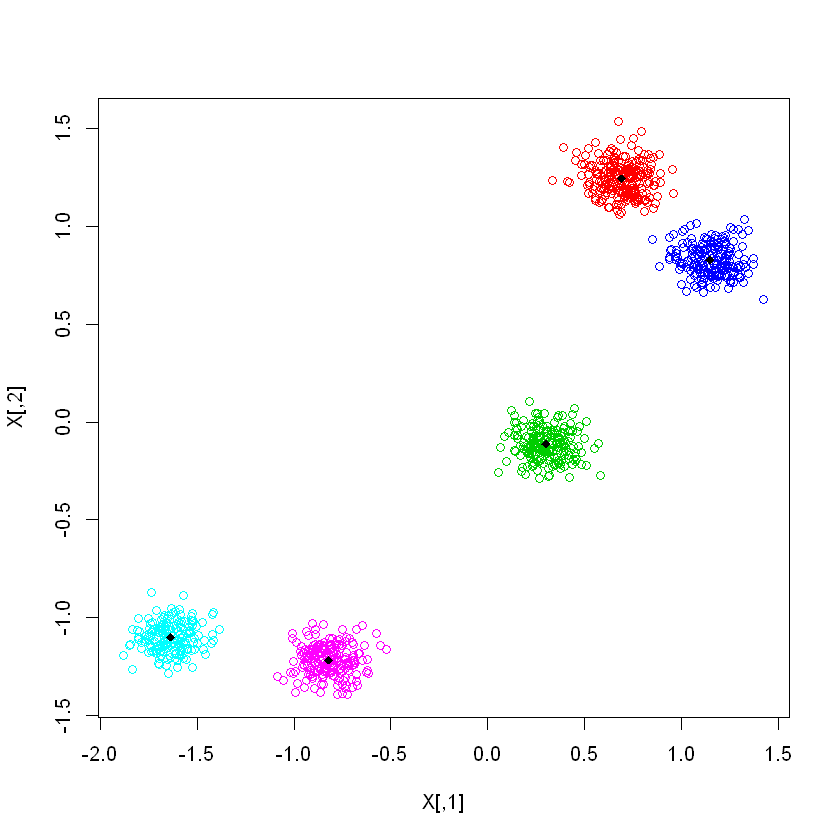

In [80]:
plot(X,col=l$label+1)
points(l$theta,pch=18,col=1)